In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from keras.models import Model
from keras.layers import Input, Dense

from evaluation import model_evaluation, backtest

2024-05-24 00:43:52.539757: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Load the data
stats = pd.read_csv('data/PlayersStats_1971-2024.csv')
shares = pd.read_csv('data/SharesSMOY_1984-2024.csv')

# Merge stats and shares
data = stats.merge(shares, how = 'left', on = ['href', 'Year'], suffixes = ['', '_y']).drop(columns = ['Player_y'])
data = data.fillna(0.)
data['GS_rate'] = data['GS'] / data['G']
data = data[(data['GS_rate'] <= 0.5) | (data['Share'] > 0)] # Eligibility
data = data[(data['G'] >= 15) & (data['MP'] >= 5)]
data = data.reset_index(drop = True)

start_year = 1990

In [5]:
features = ['PTS', 'VORP', 'WS', 'OWS', 'FG', 'MP', 'OBPM', 'PER', 'BPM', 'Seed']
features_norm = ['PTS', 'VORP', 'WS', 'OWS', 'FG', 'MP', 'OBPM', 'PER', 'BPM']

In [6]:
# Calculate means and stds by year
means = data.groupby('Year')[features_norm].transform('mean')
stds = data.groupby('Year')[features_norm].transform('std')

# Standardize features
data_norm = data.copy()
data_norm[features_norm] = (data[features_norm] - means) / stds

In [7]:
def summarize_backtest(backtests) :
    for metric in backtests.columns[-7:] :
        print(metric, backtests[metric].mean())

In [8]:
def create_nn(hidden_layers, end_activation = 'sigmoid') :

    # Input layer
    inputs = Input(shape = (len(features),))

    x = Dense(hidden_layers[0], activation = 'relu')(inputs)
    if len(hidden_layers) > 1 :
        for hidden in hidden_layers[1:] :
            x = Dense(hidden, activation = 'relu')(x)

    # Output layer
    outputs = Dense(1, activation = end_activation)(x)

    # Construct the model
    model = Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer = 'adam',
                  loss = 'binary_crossentropy',
                  metrics = ['mse', 'mae'])
    
    return model

In [9]:
# 1. Linear Regression
lr = LinearRegression()

# 2. Random Forest
rf = RandomForestRegressor(n_estimators = 250, max_depth = 12)

# 3. XGBoost
xg = xgb.XGBRegressor(n_estimators = 150, learning_rate = 0.2)

# 4. Neural Network
nn = create_nn([64, 32, 16])

In [10]:
# Run backtests
backtest_lr = backtest(start_year, data.copy(), lr, features)
backtest_rf = backtest(start_year, data_norm.copy(), rf, features)
backtest_xg = backtest(start_year, data.copy(), xg, features)
backtest_nn = backtest(start_year, data_norm.copy(), nn, features, keras = (10, 32))

[1/35] ... 1990 ...   
[2/35] ... 1991 ...   
[3/35] ... 1992 ...   
[4/35] ... 1993 ...   
[5/35] ... 1994 ...   
[6/35] ... 1995 ...   
[7/35] ... 1996 ...   
[8/35] ... 1997 ...   
[9/35] ... 1998 ...   
[10/35] ... 1999 ...   
[11/35] ... 2000 ...   
[12/35] ... 2001 ...   
[13/35] ... 2002 ...   
[14/35] ... 2003 ...   
[15/35] ... 2004 ...   
[16/35] ... 2005 ...   
[17/35] ... 2006 ...   
[18/35] ... 2007 ...   
[19/35] ... 2008 ...   
[20/35] ... 2009 ...   
[21/35] ... 2010 ...   
[22/35] ... 2011 ...   
[23/35] ... 2012 ...   
[24/35] ... 2013 ...   
[25/35] ... 2014 ...   
[26/35] ... 2015 ...   
[27/35] ... 2016 ...   
[28/35] ... 2017 ...   
[29/35] ... 2018 ...   
[30/35] ... 2019 ...   
[31/35] ... 2020 ...   
[32/35] ... 2021 ...   
[33/35] ... 2022 ...   
[34/35] ... 2023 ...   
[35/35] ... 2024 ...   
[1/35] ... 1990 ...   
[2/35] ... 1991 ...   
[3/35] ... 1992 ...   
[4/35] ... 1993 ...   
[5/35] ... 1994 ...   
[6/35] ... 1995 ...   
[7/35] ... 1996 ...   
[8/35] .

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


Linear Reg. :  34.3%
Random Forest :  51.4%
XGBoost :  42.9%
Neural Net. :  0.0%


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


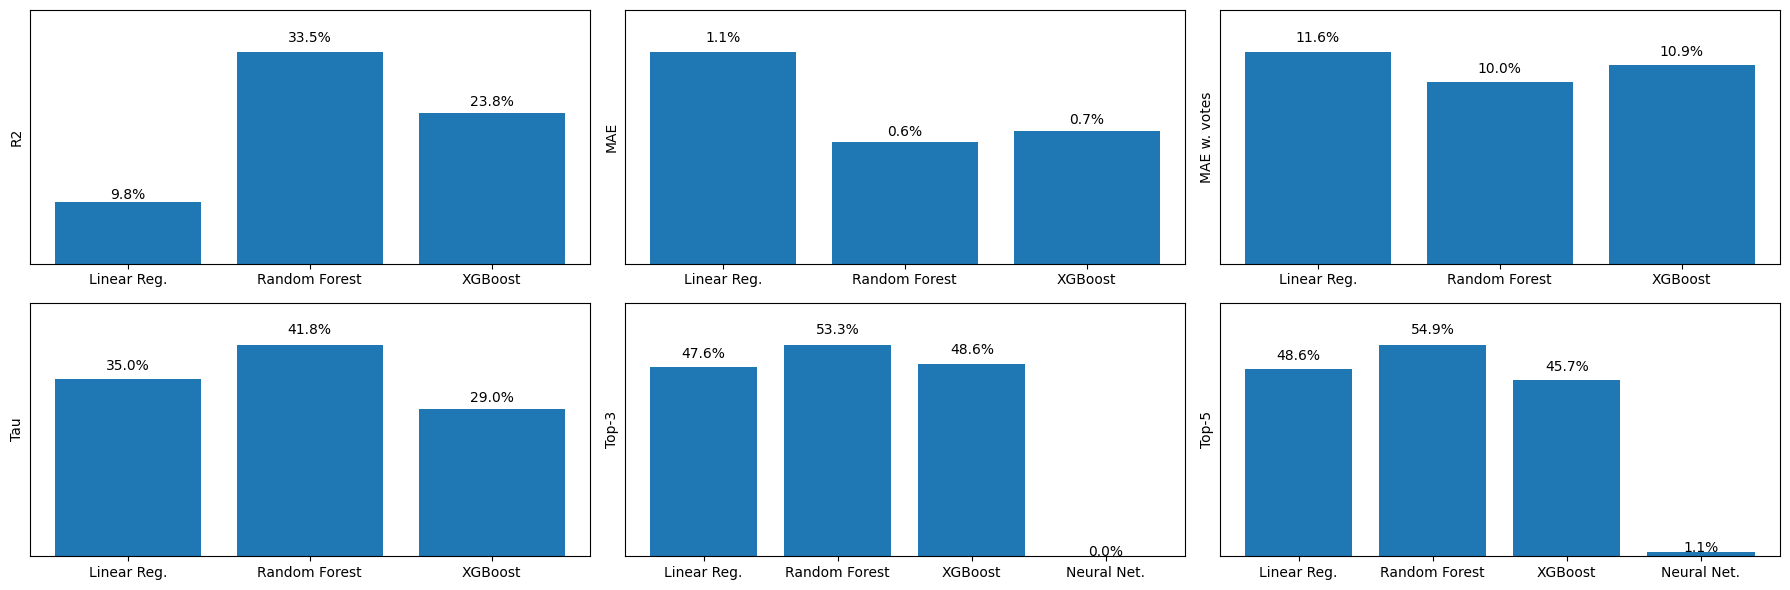

In [11]:
_, axs = plt.subplots(2, 3, figsize = (18, 6)); axs = axs.flatten()

for name, bt in zip(['Linear Reg.', 'Random Forest', 'XGBoost', 'Neural Net.'], [backtest_lr, backtest_rf, backtest_xg, backtest_nn]) :
    print(f'{name} :  {round(100*bt['Correct'].mean(), 1)}%')

for ax, metric in zip(axs, backtest_lr.columns[-6:]) :

    ax.bar(['Linear Reg.', 'Random Forest', 'XGBoost', 'Neural Net.'],
           [bt[metric].mean() for bt in [backtest_lr, backtest_rf, backtest_xg, backtest_nn]])
    
    for i, (name, bt) in enumerate(zip(['Linear Reg.', 'Random Forest', 'XGBoost', 'Neural Net.'], [backtest_lr, backtest_rf, backtest_xg, backtest_nn])) :
        ax.text(i, 1.05 * bt[metric].mean(),  str(round(100 * bt[metric].mean(), 1)) + '%', ha = 'center')

    
    ax.set_ylabel(metric)
    ax.set_ylim([0, 1.2 * max([bt[metric].mean() for bt in [backtest_lr, backtest_rf, backtest_xg, backtest_nn]])])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [13]:
backtest_rf

,Winner,Pred. share,Pred. rank,Pred. winner,Share,Rank,Correct,R2,MAE,MAE w. votes,Tau,Top-3,Top-5
Year,,,,,,,,,,,,,
1990,Ricky Pierce,0.075520,4,Hot Rod Williams,0.000,-1,False,-0.077145,0.008548,0.178971,0.596285,0.000000,0.6
1991,Detlef Schrempf,0.068560,1,Detlef Schrempf,0.396,1,True,0.182695,0.004681,0.095359,0.426006,0.666667,0.6
1992,Detlef Schrempf,0.079668,2,Dan Majerle,0.198,3,False,0.316724,0.004843,0.144866,0.527046,0.666667,0.6
1993,Clifford Robinson,0.465784,1,Clifford Robinson,0.908,1,True,0.728847,0.004289,0.111249,0.948683,0.666667,0.4
1994,Dell Curry,0.031122,2,Dennis Rodman,0.010,10,False,-0.095696,0.006365,0.109140,0.554322,0.666667,0.6
1995,Anthony Mason,0.255450,2,Danny Manning,0.000,-1,False,-1.305064,0.008072,0.072451,-0.111111,0.333333,0.4
1996,Toni Kukoč,0.041906,6,Steve Kerr,0.009,9,False,0.196340,0.005395,0.107940,-0.140859,0.333333,0.2
1997,John Starks,0.086488,3,Chris Gatling,0.052,3,False,-0.191824,0.007363,0.120264,0.447214,0.666667,0.6
1998,Danny Manning,0.024685,6,Kobe Bryant,0.267,2,False,0.123626,0.005317,0.135751,0.195180,0.333333,0.4
